Running TEM simulation

In [1]:
"""
This file runs a training simulation for the Whittington et al. 2020 agent, the Tolman-Eichenbaum Machine (TEM).
The TEM is a model of the hippocampus that learns to navigate a series of environments and solve a series of tasks.
"""

import os

import numpy as np

from neuralplayground.agents.whittington_2020 import Whittington2020
from neuralplayground.agents.TaskTEM import TaskAgent
from neuralplayground.agents.whittington_2020_extras import whittington_2020_parameters as parameters
from neuralplayground.arenas import BatchEnvironment, DiscreteObjectEnvironment
from neuralplayground.backend import SingleSim, tem_training_loop
from neuralplayground.experiments import Sargolini2006Data

simulation_id = "Task"
save_path = os.path.join(os.getcwd(), "results_sim")
# save_path = os.path.join(os.getcwd(), "examples", "agent_examples", "trained_results")
agent_class = TaskAgent
env_class = BatchEnvironment
training_loop = tem_training_loop

params = parameters.parameters()
full_agent_params = params.copy()

batch_size = 16
params["batch_size"] = batch_size
full_agent_params["batch_size"] = batch_size

params["n_rollout"] = 50 
full_agent_params = params.copy()

"""
arena_x_limits = [
    [-5, 5],
    [-4, 4],
    [-5, 5],
    [-6, 6],
    [-4, 4],
    [-5, 5],
    [-6, 6],
    [-5, 5],
    [-4, 4],
    [-5, 5],
    [-6, 6],
    [-5, 5],
    [-4, 4],
    [-5, 5],
    [-6, 6],
    [-5, 5],
]
arena_y_limits = [
    [-5, 5],
    [-4, 4],
    [-5, 5],
    [-6, 6],
    [-4, 4],
    [-5, 5],
    [-6, 6],
    [-5, 5],
    [-4, 4],
    [-5, 5],
    [-6, 6],
    [-5, 5],
    [-4, 4],
    [-5, 5],
    [-6, 6],
    [-5, 5],
]

room_widths = [int(np.diff(arena_x_limits)[i]) for i in range(len(arena_x_limits))]
room_depths = [int(np.diff(arena_y_limits)[i]) for i in range(len(arena_y_limits))]
"""

standard_room_limits = [-5, 5]
arena_x_limits = [standard_room_limits] * batch_size
arena_y_limits = [standard_room_limits] * batch_size

room_widths = [int(np.diff(arena_x_limits)[i]) for i in range(len(arena_x_limits))]
room_depths = [int(np.diff(arena_y_limits)[i]) for i in range(len(arena_y_limits))]


discrete_env_params = {
    "environment_name": "DiscreteObject",
    "state_density": 1,
    "n_objects": params["n_x"],
    "agent_step_size": 1,
    "use_behavioural_data": False,
    "data_path": None,
    "experiment_class": Sargolini2006Data,
}

env_params = {
    "environment_name": "BatchEnvironment",
    "batch_size": batch_size,
    "arena_x_limits": arena_x_limits,
    "arena_y_limits": arena_y_limits,
    "env_class": DiscreteObjectEnvironment,
    "arg_env_params": discrete_env_params,
}
agent_params = {
    "model_name": "randompoints",
    "params": full_agent_params,
    "batch_size": env_params["batch_size"],
    "room_widths": room_widths,
    "room_depths": room_depths,
    "state_densities": [discrete_env_params["state_density"]] * env_params["batch_size"],
    "use_behavioural_data": False,
    "points":  [(-3, 3), (-3, 1), (-2, 2), (-1, 1), (0, 0), (1, -1), (2, -2), (3, -3),
    (-3, -3), (3, 3), (0, 3), (3, 0), (-2, -2), (2, 3), (1, 3), (-3, -1)]
}

# Full model training consists of 20000 episodes
training_loop_params = {"n_episode": 400, "params": full_agent_params}

sim = SingleSim(
    simulation_id=simulation_id,
    agent_class=agent_class,
    agent_params=agent_params,
    env_class=env_class,
    env_params=env_params,
    training_loop=training_loop,
    training_loop_params=training_loop_params,
)

# print(sim)
print("Running sim...")
sim.run_sim(save_path)
print("Sim finished.")

/var/folders/f_/_pccgc955s77sxdv6dny1hkh0000gn/T/ipykernel_95530/362278681.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  room_widths = [int(np.diff(arena_x_limits)[i]) for i in range(len(arena_x_limits))]
/var/folders/f_/_pccgc955s77sxdv6dny1hkh0000gn/T/ipykernel_95530/362278681.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  room_depths = [int(np.diff(arena_y_limits)[i]) for i in range(len(arena_y_limits))]


Running sim...
---> Saving simulation parameters
---> Initializing models
---> Training loop
Starting training for 400 episodes...
  Episode 400/400 [100.0%] | Elapsed: 00:23:41 | ETA: 00:00:00  
---> Saving models
---> Simulation finished
Sim finished.


Plotting TEM Results:

In [2]:
import importlib
import os
import pickle

import pandas as pd

from neuralplayground.comparison import GridScorer
from neuralplayground.plotting import PlotSim

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_task_trajectory(agent, history_data, ax, agent_id=0):
    """
    Plots a task-specific trajectory for a single agent from a batch.
    """
    # Extract the trajectory for the specified agent
    trajectory = [step[agent_id]["state"] for step in history_data]
    if not trajectory:
        print("History data is empty. Cannot plot trajectory.")
        return

    x = np.array([pos[0] for pos in trajectory])
    y = np.array([pos[1] for pos in trajectory])

    ax.set_title(f"Task-Specific Trajectory for Agent {agent_id}")
    ax.set_xlabel("Width")
    ax.set_ylabel("Depth")
    ax.grid(True, linestyle='--', alpha=0.6)

    # Plot the full path in a light color as a background guide
    ax.plot(x, y, color='gray', alpha=0.4, zorder=1, label='Full Path')

    # Plot the predefined target points
    target_x, target_y = zip(*agent.points)
    ax.scatter(target_x, target_y, c='black', s=150, marker='X', label='Target Points', zorder=5)

    # Use the agent's state counter logic to identify and plot each phase
    special_move_counter = 0
    for i in range(len(x) - 1):
        start_pos = (x[i], y[i])
        end_pos = (x[i+1], y[i+1])
        target_pos = None

        distances = [np.linalg.norm(start_pos - p) for p in agent.points]
        closest_target_index = np.argmin(distances)
        target_pos = agent.points[closest_target_index]

        if np.linalg.norm(start_pos - target_pos) < 1.0:
            special_move_counter = 1

        if special_move_counter == 1:
            ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]],
                    color='green', alpha=0.8, linewidth=2.5, marker='^', markersize=8,
                    label='Up Move' if 'Up Move' not in [l.get_label() for l in ax.get_legend_handles_labels()[1]] else "")
            special_move_counter = 2
        
        elif special_move_counter == 2:
            ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]],
                    color='red', alpha=0.8, linewidth=2.5, marker='>', markersize=8,
                    label='Right Move' if 'Right Move' not in [l.get_label() for l in ax.get_legend_handles_labels()[1]] else "")
            special_move_counter = 0
            
        else:
            ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]],
                    color='blue', alpha=0.6, linewidth=1.5,
                    label='Navigating' if 'Navigating' not in [l.get_label() for l in ax.get_legend_handles_labels()[1]] else "")

    ax.legend(loc='upper right')
    ax.set_aspect('equal', adjustable='box')

In [4]:
simulation_id = "TEM_custom_plot_sim"
from neuralplayground.saved_models import fetch_model_path

#save_path = fetch_model_path("whittington_2020_in_discritized_objects")
print(save_path)
plotting_loop_params = {"n_episode": 5000}

/Users/devanshishah/Documents/TEM/NeuralPlayground/results_sim


In [5]:
training_dict = pd.read_pickle(os.path.join(os.getcwd(), save_path, "params.dict"))
model_weights = pd.read_pickle(os.path.join(save_path, "agent"))
model_spec = importlib.util.spec_from_file_location("model", save_path + "/whittington_2020_model.py")
model = importlib.util.module_from_spec(model_spec)
model_spec.loader.exec_module(model)
params = pd.read_pickle(os.path.join(save_path, "agent_hyper"))
tem = model.Model(params)
tem.load_state_dict(model_weights)
tem.eval()

Model(
  (alpha): ParameterList(
      (0): Parameter containing: [torch.float32 of size ]
      (1): Parameter containing: [torch.float32 of size ]
      (2): Parameter containing: [torch.float32 of size ]
      (3): Parameter containing: [torch.float32 of size ]
      (4): Parameter containing: [torch.float32 of size ]
  )
  (w_p): ParameterList(
      (0): Parameter containing: [torch.float32 of size ]
      (1): Parameter containing: [torch.float32 of size ]
      (2): Parameter containing: [torch.float32 of size ]
      (3): Parameter containing: [torch.float32 of size ]
      (4): Parameter containing: [torch.float32 of size ]
  )
  (g_init): ParameterList(
      (0): Parameter containing: [torch.float32 of size 30]
      (1): Parameter containing: [torch.float32 of size 30]
      (2): Parameter containing: [torch.float32 of size 24]
      (3): Parameter containing: [torch.float32 of size 18]
      (4): Parameter containing: [torch.float32 of size 18]
  )
  (logsig_g_init): Param

In [6]:
sim = PlotSim(
    simulation_id=simulation_id,
    agent_class=training_dict["agent_class"],
    agent_params=training_dict["agent_params"],
    env_class=training_dict["env_class"],
    env_params=training_dict["env_params"],
    plotting_loop_params=plotting_loop_params,
)

---> Initializing models
---> Plotting loop
---> Finished


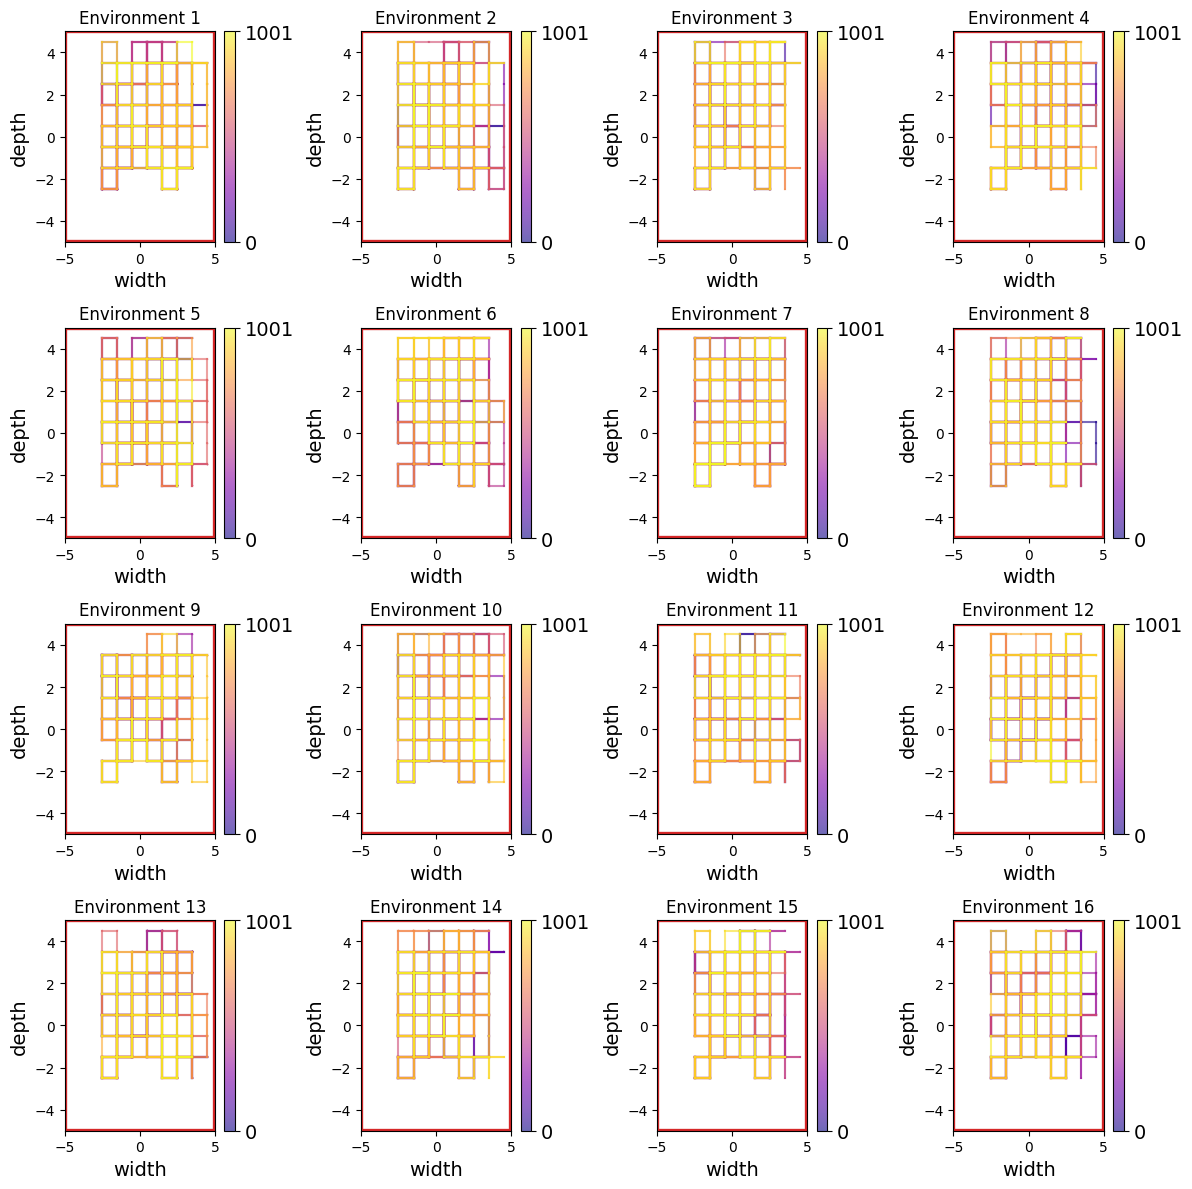

In [7]:
trained_agent, trained_env = sim.plot_sim(save_path, n_walks=1000, random_state=False, custom_state=[0.5,0.5])
trained_env.plot_trajectories();

In [1]:
trained_agent, trained_env = sim.plot_sim(save_path, n_walks=1000, random_state=False, custom_state=[0.5,0.5])

# --- NEW PLOTTING CODE ---
# Create a figure to plot the trajectories of the first 4 agents
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

# Get the full history from the trained environment
full_history = trained_env.history

for i in range(min(4, agent.batch_size)): # Plot up to 4 agents
    plot_task_trajectory(agent=trained_agent, 
                         history_data=full_history, 
                         ax=axes[i], 
                         agent_id=i)

plt.tight_layout()
plt.show()

NameError: name 'sim' is not defined

In [ ]:
with open(os.path.join(save_path, "NPG_environments.pkl"), "rb") as f:
    environments = pickle.load(f)
with open(os.path.join(save_path, "NPG_model_input.pkl"), "rb") as f:
    model_input = pickle.load(f)

In [ ]:
training_dict["params"] = training_dict["agent_params"]
del training_dict["agent_params"]
agent = training_dict["agent_class"](**training_dict["params"])
agent.plot_run(tem, model_input, environments)

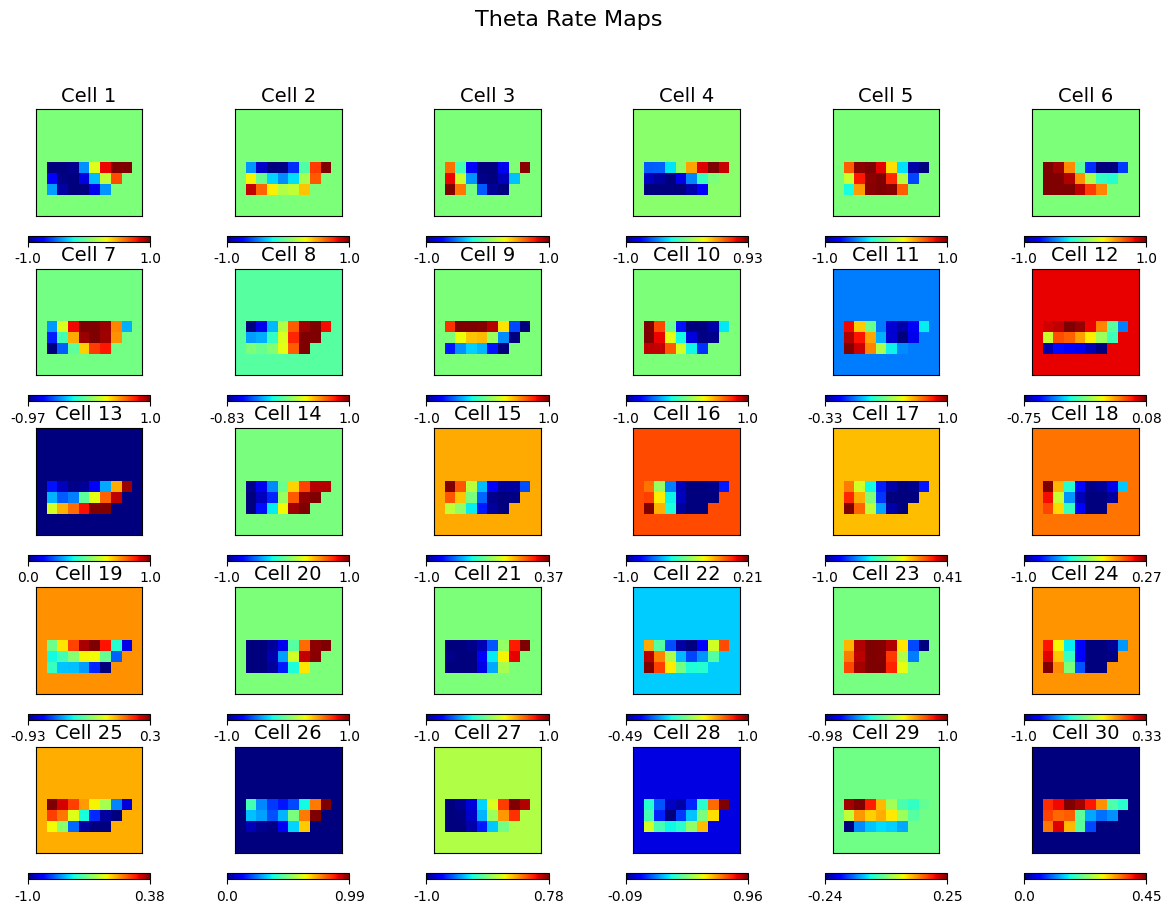

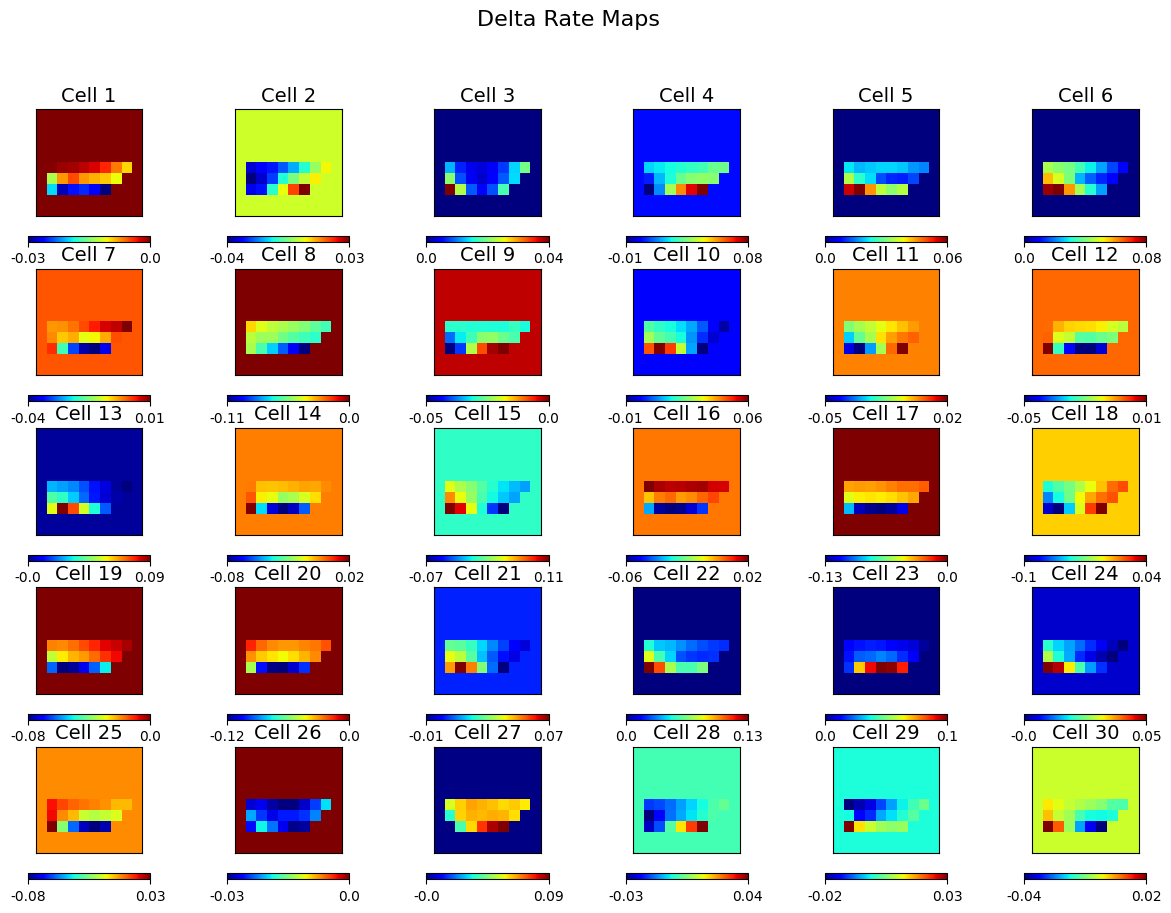

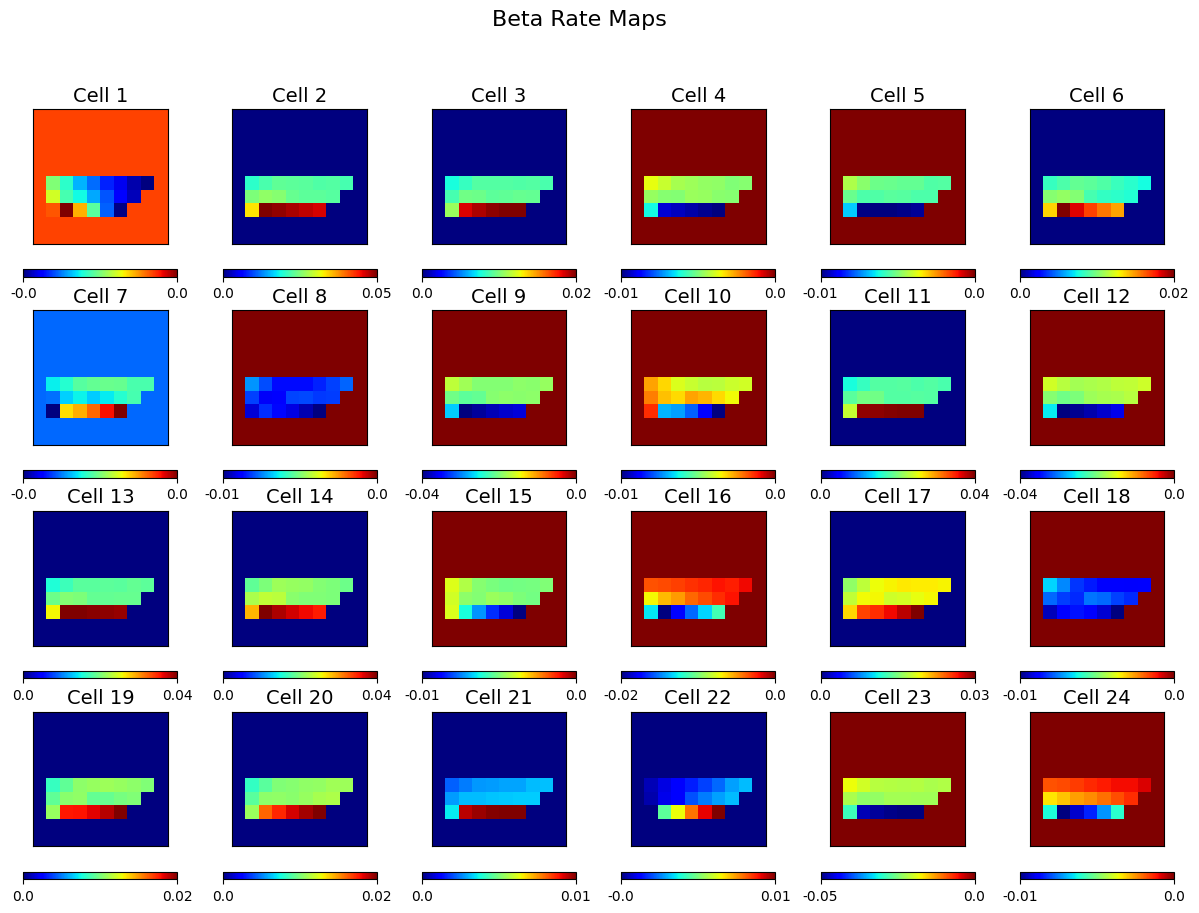

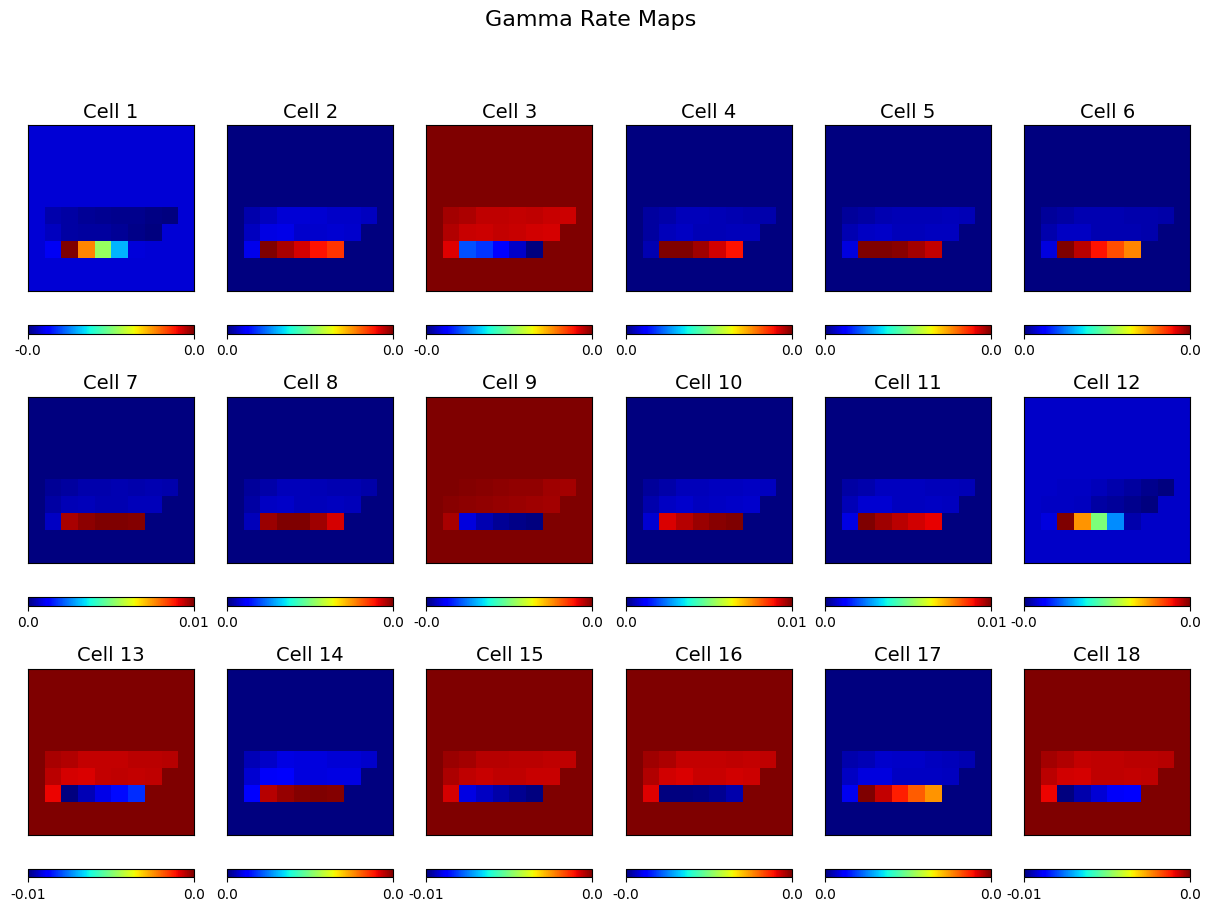

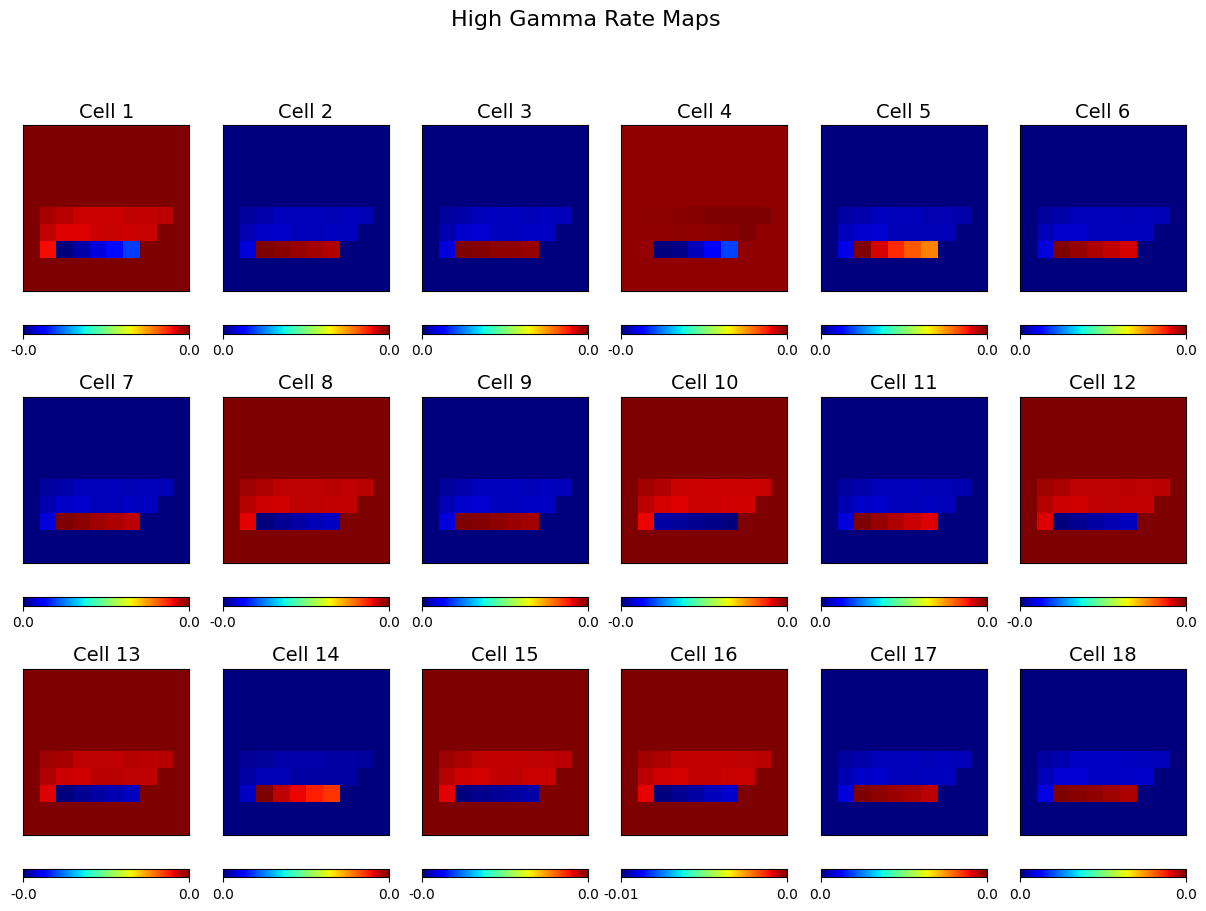

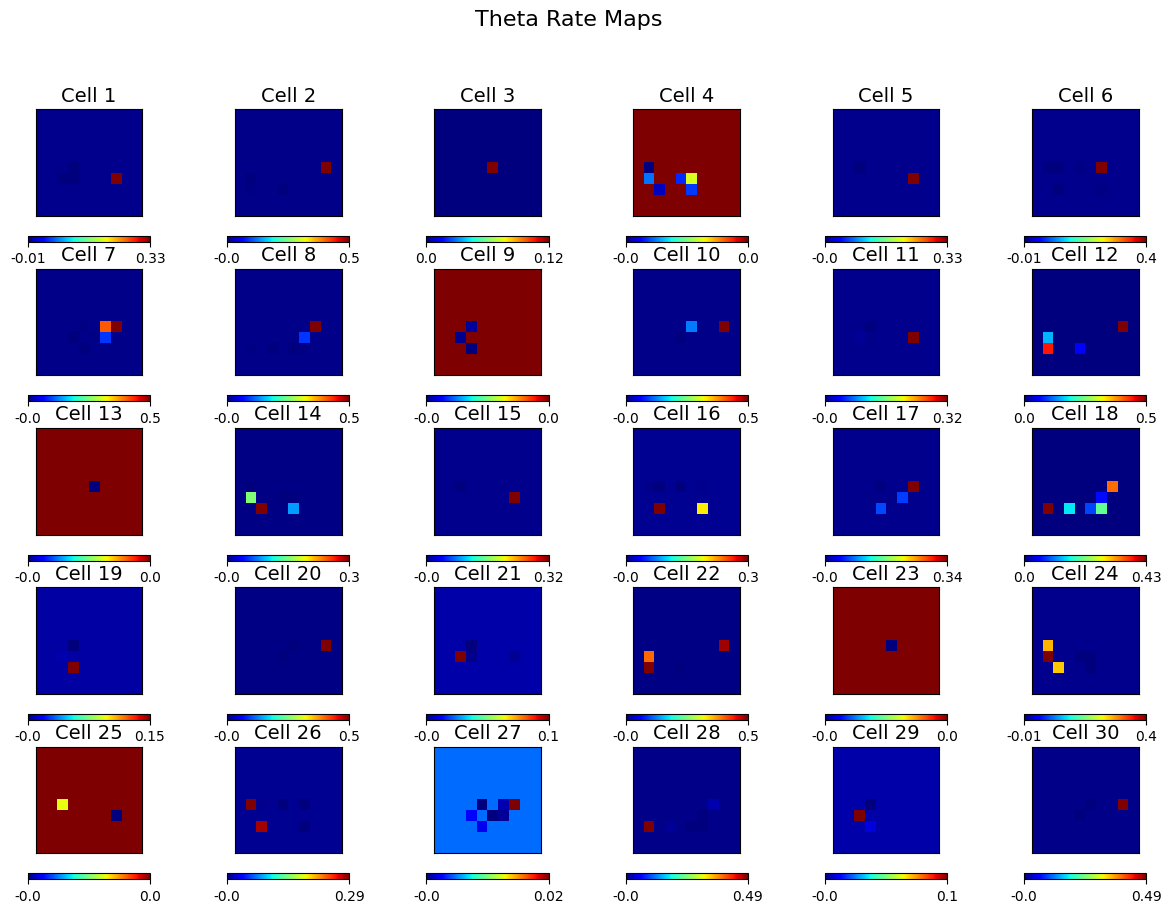

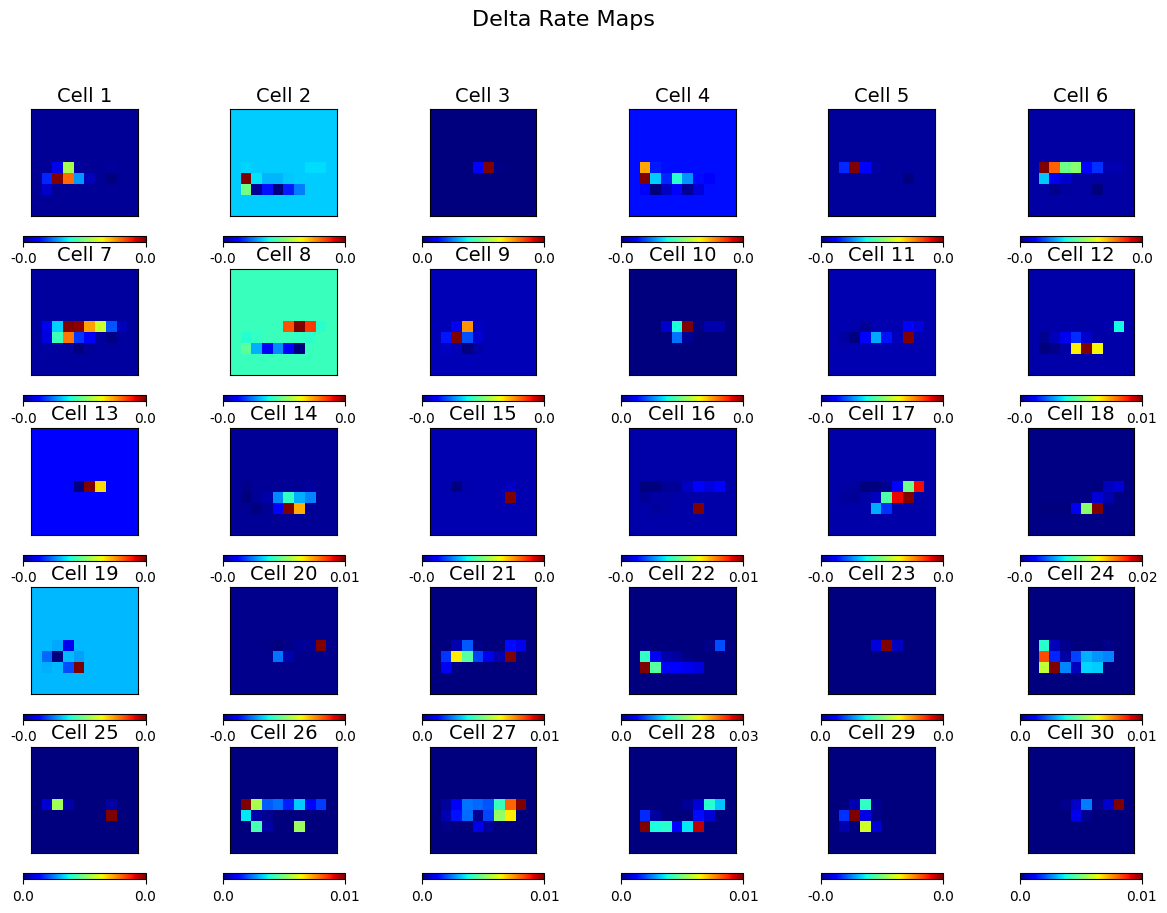

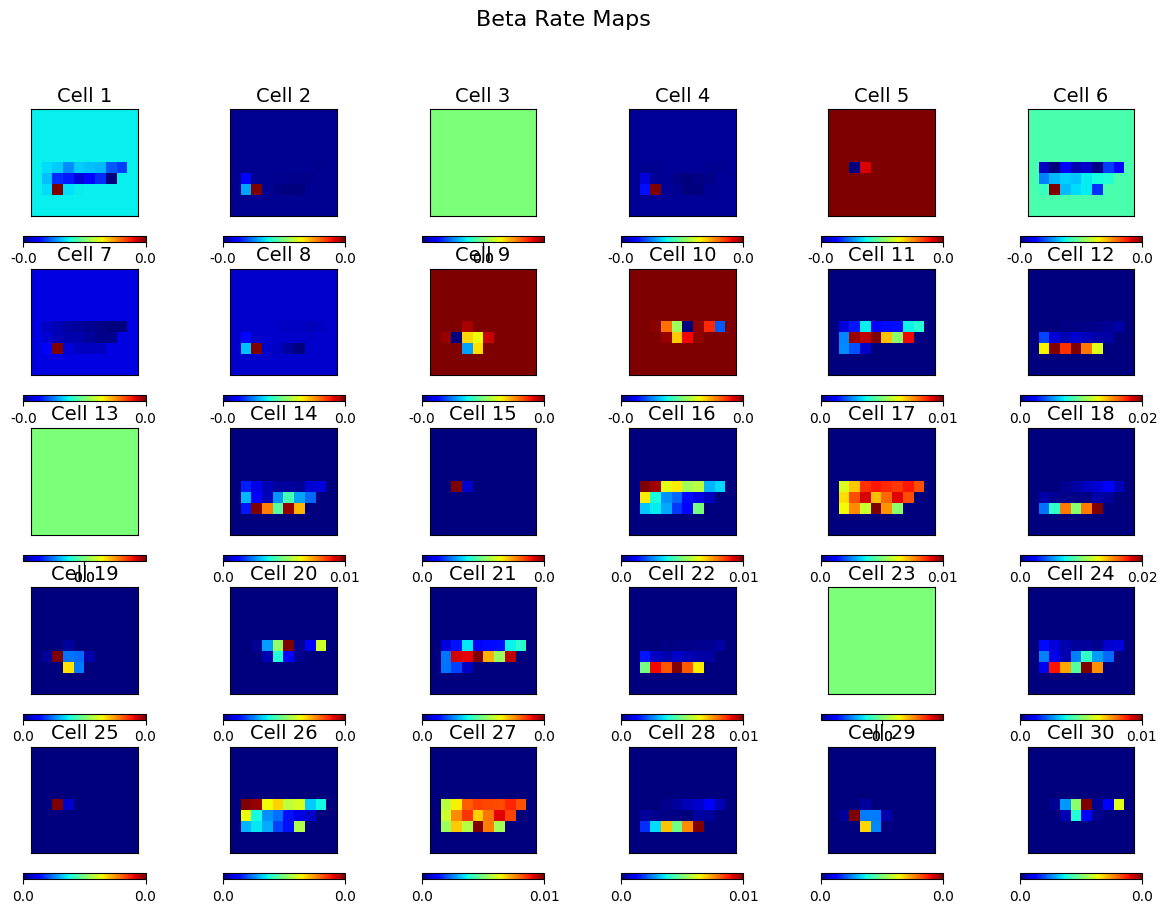

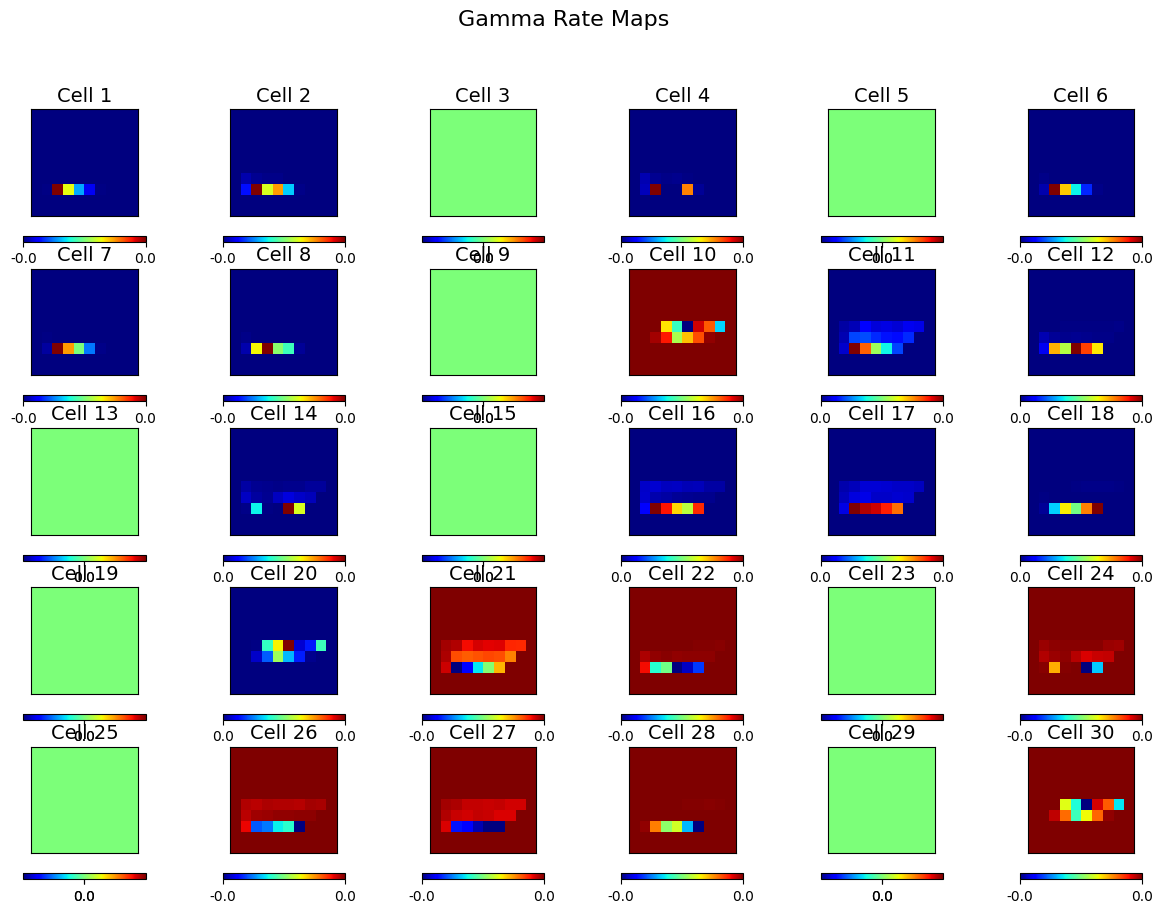

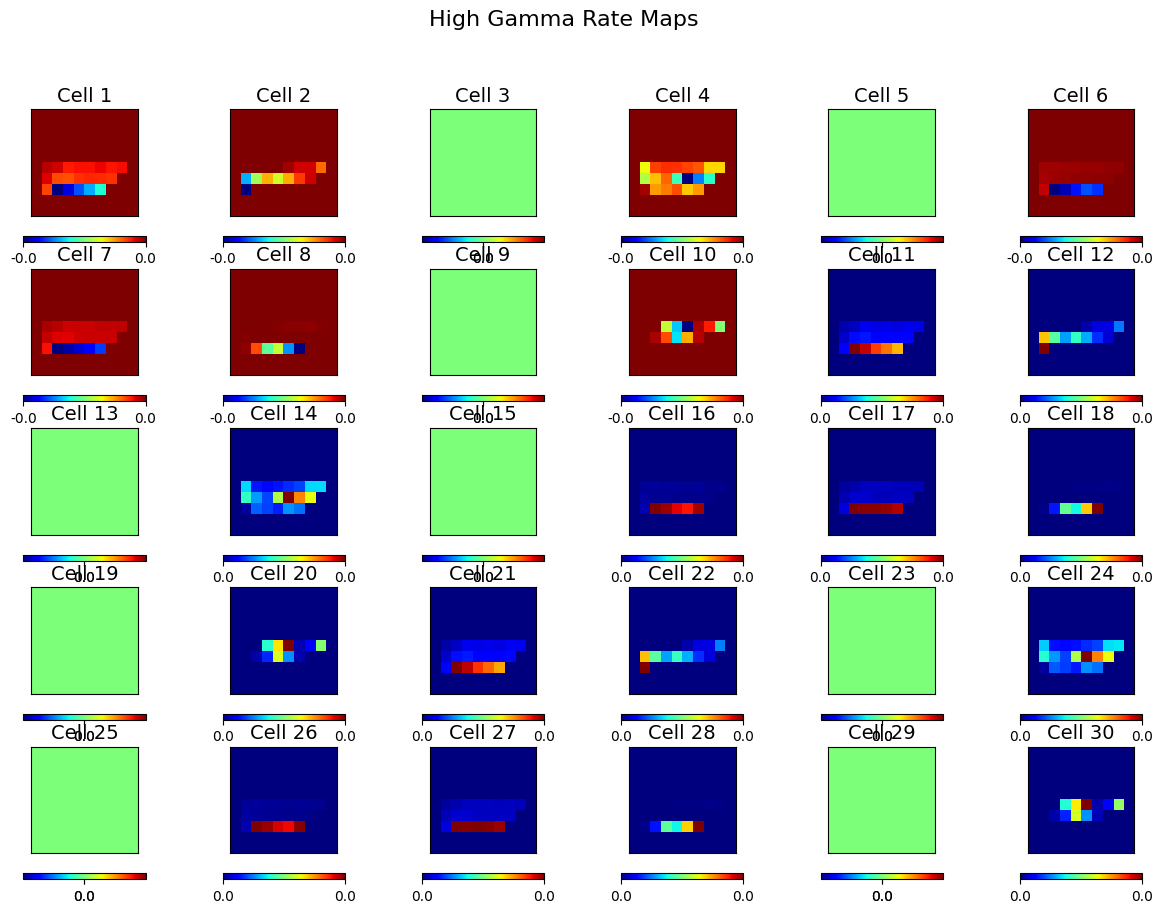

In [ ]:
agent.plot_rate_map(rate_map_type='g')
agent.plot_rate_map(rate_map_type='p');

/Users/devanshishah/Documents/TEM/NeuralPlayground/neuralplayground/comparison/metrics.py:121: RuntimeWarning: invalid value encountered in divide
  A = np.squeeze(mapCovar / mapStd / mapStd[::-1, :, :][:, ::-1, :][:, :, :])
/Users/devanshishah/Documents/TEM/NeuralPlayground/neuralplayground/comparison/metrics.py:270: RuntimeWarning: Need at least 5 data points to estimate an ellipse.
  E.estimate(ellipse_fit_coords)
/Users/devanshishah/Documents/TEM/NeuralPlayground/neuralplayground/comparison/metrics.py:121: RuntimeWarning: invalid value encountered in divide
  A = np.squeeze(mapCovar / mapStd / mapStd[::-1, :, :][:, ::-1, :][:, :, :])
/Users/devanshishah/Documents/TEM/NeuralPlayground/neuralplayground/comparison/metrics.py:270: RuntimeWarning: Need at least 5 data points to estimate an ellipse.
  E.estimate(ellipse_fit_coords)


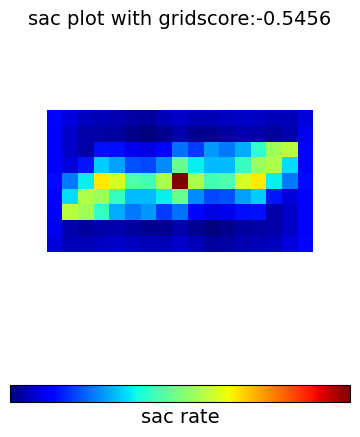

In [ ]:
rate_map_mat = agent.get_rate_map_matrix(agent.g_rates,1,2)
GridScorer = GridScorer(rate_map_mat.shape[0])
GridScorer.plot_grid_score(r_out_im = rate_map_mat, plot= True)
score = GridScorer.get_scores(rate_map_mat)